In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
from skimage.data import coffee

sys.path.append('..')
from libs import gif, inception, utils

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
s = tf.InteractiveSession()
net = inception.get_inception_model()

In [3]:
tf.import_graph_def(net['graph_def'], name='inception')

In [4]:
g = tf.get_default_graph()

In [5]:
names = [op.name for op in g.get_operations()]

In [6]:
names[:30]

['inception/input',
 'inception/conv2d0_w',
 'inception/conv2d0_b',
 'inception/conv2d1_w',
 'inception/conv2d1_b',
 'inception/conv2d2_w',
 'inception/conv2d2_b',
 'inception/mixed3a_1x1_w',
 'inception/mixed3a_1x1_b',
 'inception/mixed3a_3x3_bottleneck_w',
 'inception/mixed3a_3x3_bottleneck_b',
 'inception/mixed3a_3x3_w',
 'inception/mixed3a_3x3_b',
 'inception/mixed3a_5x5_bottleneck_w',
 'inception/mixed3a_5x5_bottleneck_b',
 'inception/mixed3a_5x5_w',
 'inception/mixed3a_5x5_b',
 'inception/mixed3a_pool_reduce_w',
 'inception/mixed3a_pool_reduce_b',
 'inception/mixed3b_1x1_w',
 'inception/mixed3b_1x1_b',
 'inception/mixed3b_3x3_bottleneck_w',
 'inception/mixed3b_3x3_bottleneck_b',
 'inception/mixed3b_3x3_w',
 'inception/mixed3b_3x3_b',
 'inception/mixed3b_5x5_bottleneck_w',
 'inception/mixed3b_5x5_bottleneck_b',
 'inception/mixed3b_5x5_w',
 'inception/mixed3b_5x5_b',
 'inception/mixed3b_pool_reduce_w']

In [7]:
input_name = names[0] + ':0'

In [8]:
x = g.get_tensor_by_name(input_name)

In [9]:
softmax = g.get_tensor_by_name(names[-1] + ':0')

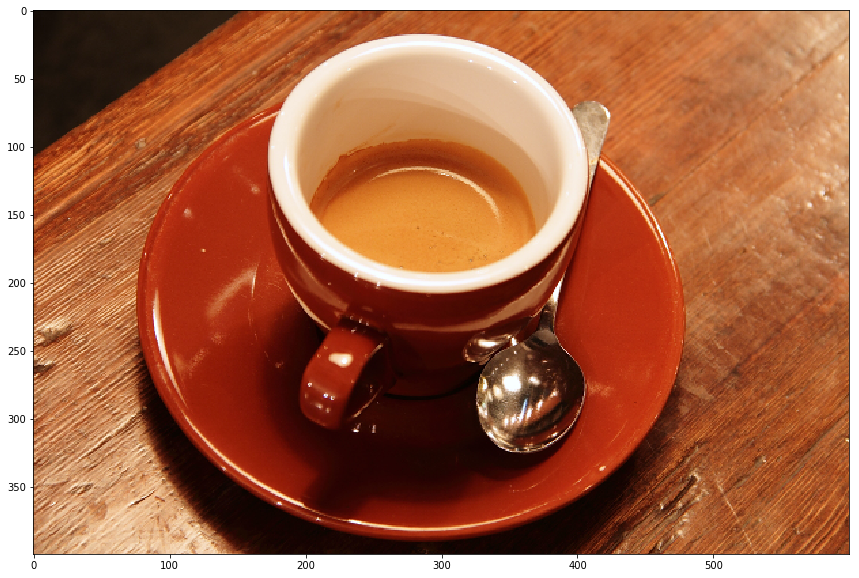

In [10]:
og = coffee()
plt.imshow(og);

In [11]:
og.shape

(400, 600, 3)

In [12]:
img = inception.preprocess(og) # crop, resize, and subtract from mean
print(img.shape)
#plt.imshow(img);

(299, 299, 3)


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
# Reshape to img processing standard tensor ([batch, h, w, c])
img4d = img[np.newaxis]
img4d.shape

(1, 299, 299, 3)

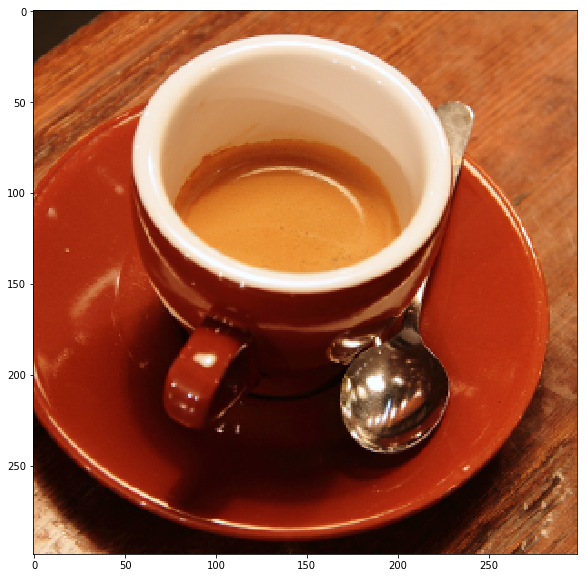

In [14]:
img = img.astype(np.uint8)
plt.imshow(inception.deprocess(img)); # add mean value back in

In [15]:
res = np.squeeze(softmax.eval(feed_dict={x: img4d}))

In [16]:
# Get top predictions
res = np.mean(res, 0)
res = res / np.sum(res)
[(res[idx], net['labels'][idx]) for idx in res.argsort()[-10:][::-1]]

[(0.99849206, (947, 'espresso')),
 (0.000631253, (859, 'cup')),
 (0.00050241494, (953, 'chocolate sauce')),
 (0.00019483209, (844, 'consomme')),
 (0.00013370356, (822, 'soup bowl')),
 (2.2646054e-05, (996, 'coffee mug')),
 (1.0453795e-05, (823, 'eggnog')),
 (2.8054892e-06, (514, 'strainer')),
 (2.4793335e-06, (798, 'red wine')),
 (2.4155261e-06, (892, 'ladle'))]

In [17]:
# Attempt visualization of network filters
W = g.get_tensor_by_name('inception/conv2d0_w:0')
W_eval = W.eval()
W_eval.shape

(7, 7, 3, 64)

In [18]:
W_montage = utils.montage_filters(W_eval)

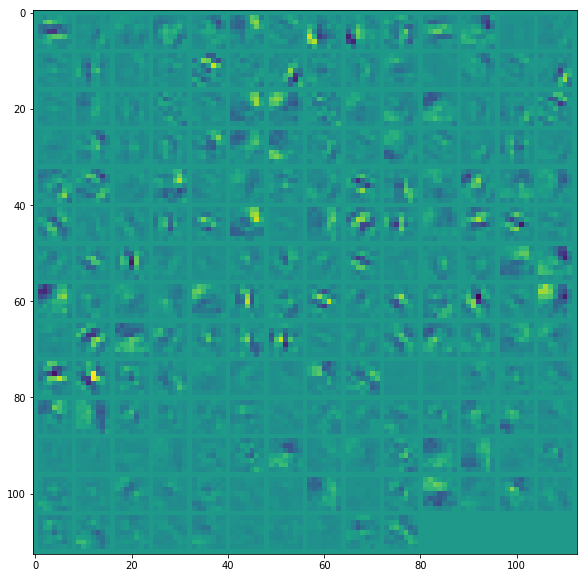

In [19]:
plt.imshow(W_montage, interpolation='nearest');

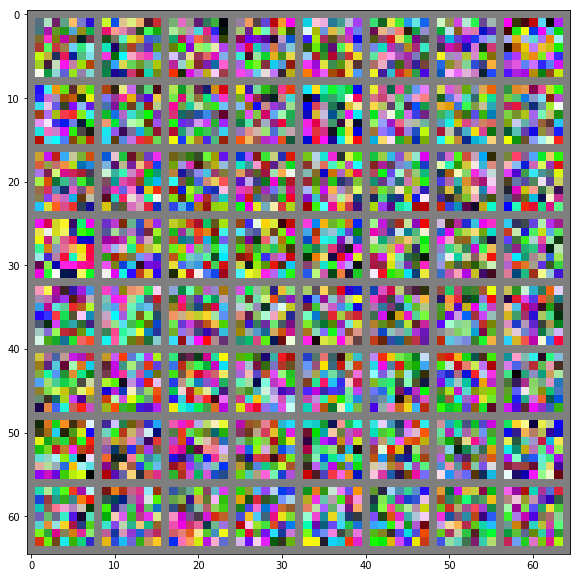

In [20]:
# Parse by color channel
Ws = [utils.montage_filters(W_eval[:, :, [i], :]) for i in range(3)]
Ws = np.rollaxis(np.array(Ws), 0, 3)
plt.imshow(Ws, interpolation='nearest');

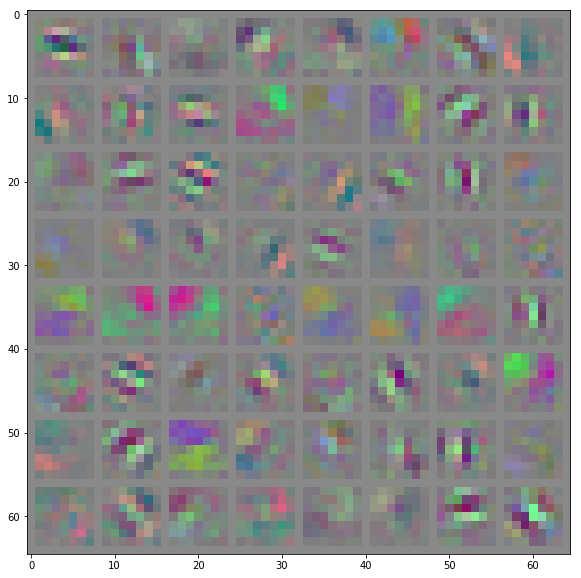

In [21]:
# Normalize ranges
Ws = (Ws / np.max(np.abs(Ws)) * 128 + 128).astype(np.uint8)
plt.imshow(Ws, interpolation='nearest');

In [22]:
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
layer_shape = tf.shape(feature).eval(feed_dict={x: img4d})
layer_shape # 150x150 bc stride of 2 in convolution; 64 output channels

array([  1, 150, 150,  64], dtype=int32)

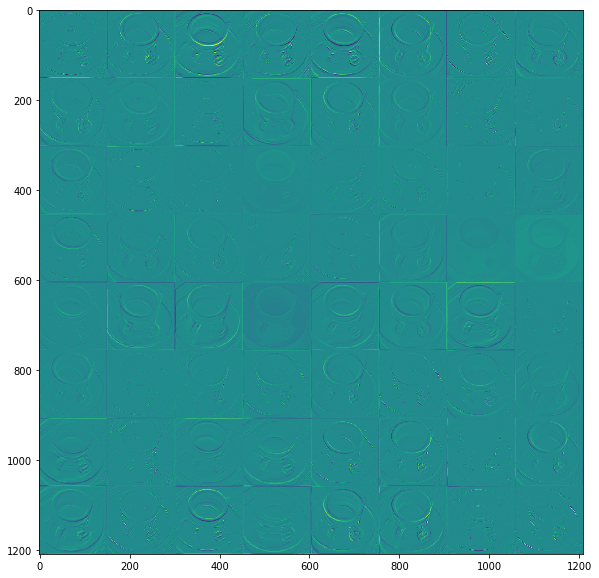

In [23]:
# visualize resulting convolution
f = feature.eval(feed_dict={x: img4d})
montage = utils.montage_filters(np.rollaxis(np.expand_dims(f[0], 3), 3, 2))
plt.imshow(montage);

In [24]:
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')

In [25]:
gradient = tf.gradients(tf.reduce_max(feature, 3), x)

In [26]:
res = s.run(gradient, feed_dict={x: img4d})[0]

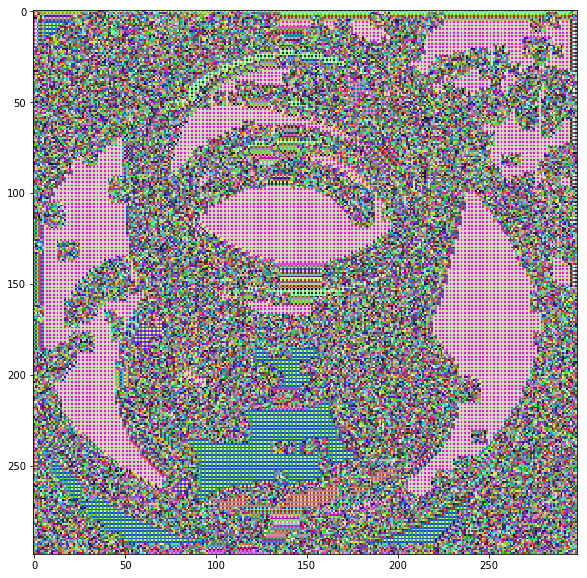

In [28]:
plt.imshow(res[0]);

In [29]:
def normalize(img, s=0.1):
    z = img / np.std(img)
    return np.uint8(np.clip((z - z.mean()) / max(z.std(), 1e-4) * s + 0.5,
                            0,
                            1) * 255)

In [30]:
r = normalize(res)

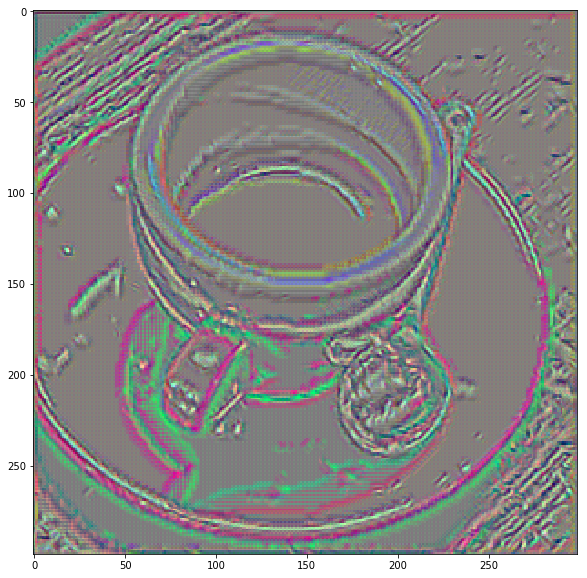

In [32]:
plt.imshow(r[0]);

In [33]:
def compute_gradient(input_placeholder, img, layer_name, neuron_i):
    feature = g.get_tensor_by_name(layer_name)
    gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), x)
    return s.run(gradient, feed_dict={input_placeholder: img})[0]

In [35]:
def compute_gradients(input_placeholder, img, layer_name):
    feature = g.get_tensor_by_name(layer_name)
    layer_shape = tf.shape(feature)\
        .eval(feed_dict={input_placeholder: img})
    gradients = []
    for neuron_i in range(layer_shape[-1]):
        gradients.append(compute_gradient(
            input_placeholder, img, layer_name, neuron_i))
    return gradients

In [36]:
gradients = compute_gradients(x, img4d, 'inception/conv2d1_pre_relu:0')

In [37]:
gradients_norm = [normalize(grad[0]) for grad in gradients]

In [38]:
montage = utils.montage(np.array(gradients_norm))

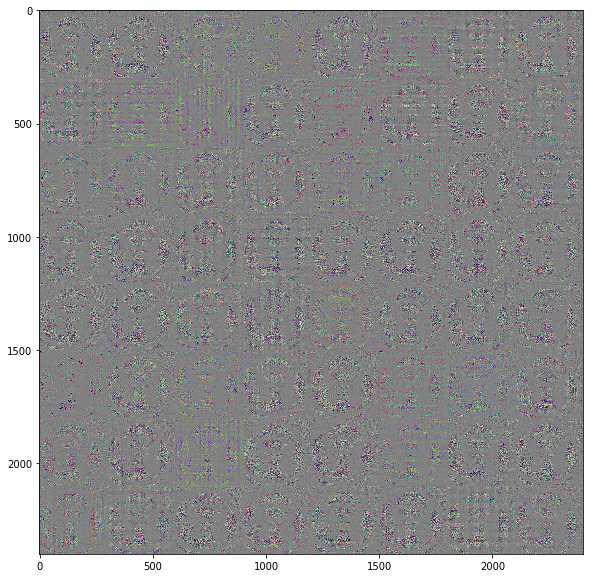

In [40]:
plt.imshow(montage, interpolation='nearest');

In [42]:
features = [name for name in names if 'maxpool' in name.split()[-1]]
features

['inception/maxpool0',
 'inception/maxpool1',
 'inception/maxpool4',
 'inception/maxpool10']

In [43]:
base = img4d

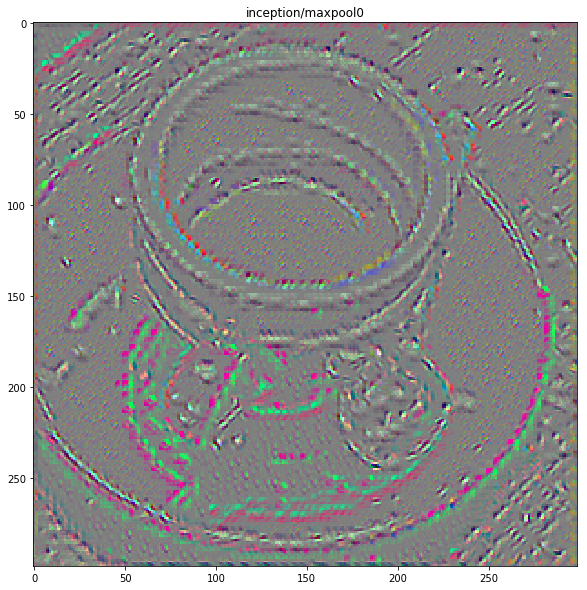

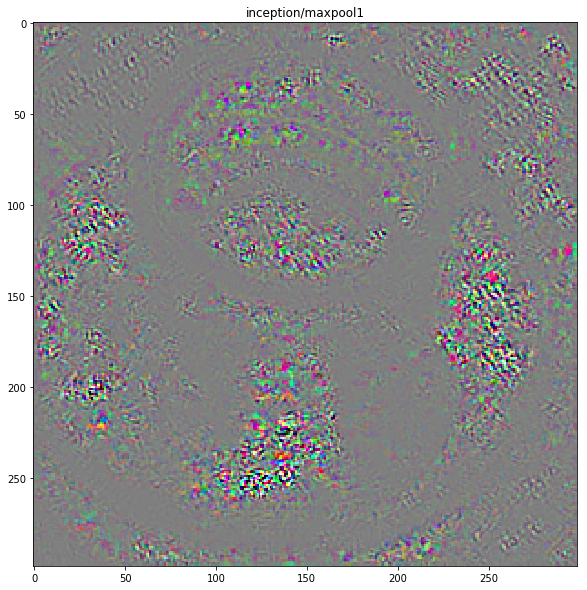

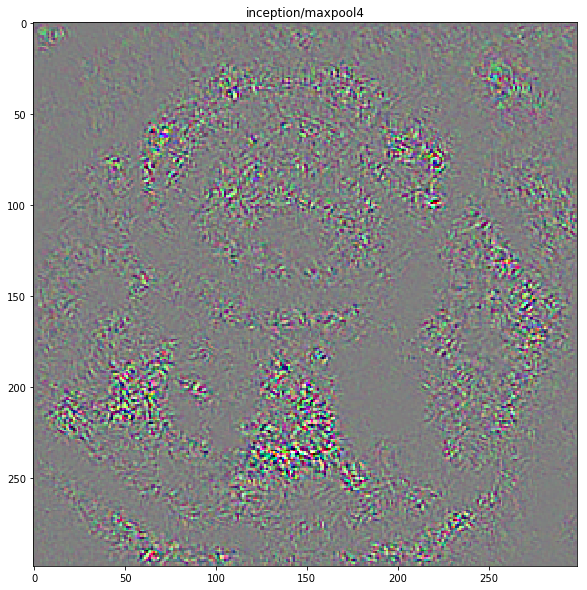

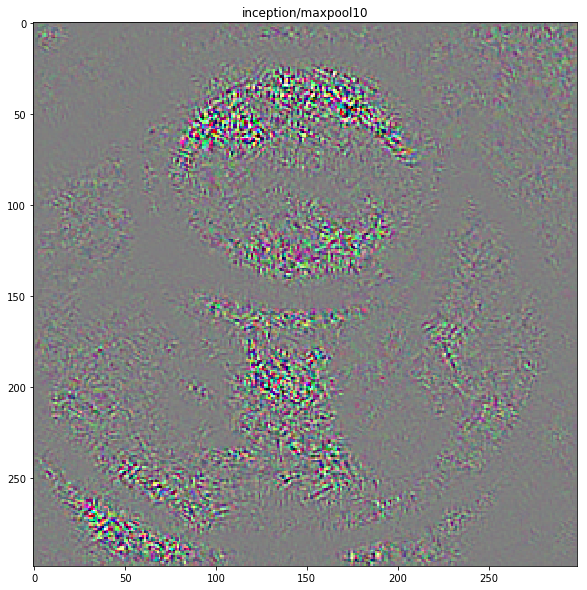

In [44]:
for feature_i, feature_name in enumerate(features):
    feature = g.get_tensor_by_name(feature_name + ':0')
    neuron = tf.reduce_max(feature, len(feature.get_shape()) - 1)
    grad = tf.gradients(tf.reduce_sum(neuron), x)
    this_res = s.run(grad[0], feed_dict={x: base})[0]
    plt.figure()
    plt.imshow(normalize(this_res))
    plt.title(feature_name)